In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import datetime

device = torch.device("cuda:0")

path = "./车辆分类数据集/bus/bus001.jpg"
train_features = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
test_features = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)

# 处理客车数据，总共218张，前153张为训练集，后65张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/bus/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/bus/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 153:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

# 处理汽车数据，总共779张，前545张为训练集，后234张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/car/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/car/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 545:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

# 处理货车数据，总共360张，前252张为训练集，后108张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/truck/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/truck/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 252:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

train_features = train_features.permute(0,3,2,1)
test_features = test_features.permute(0,3,2,1)
print(train_features.shape)
print(test_features.shape)

# =================== 训练集标签 =================== #
train_labels = torch.zeros(154).long()
train_labels = torch.cat((train_labels,torch.ones(545).long()), dim=0)
train_labels = torch.cat((train_labels,torch.ones(252).long()+1), dim=0)
print(train_labels.shape)

# =================== 测试集标签 =================== #
test_labels = torch.zeros(66).long()
test_labels = torch.cat((test_labels,torch.ones(234).long()), dim=0)
test_labels = torch.cat((test_labels,torch.ones(108).long()+1), dim=0)
print(test_labels.shape)

torch.Size([951, 3, 100, 100])
torch.Size([408, 3, 100, 100])
torch.Size([951])
torch.Size([408])


In [2]:
# ========================= 定义模型 ========================= #
 
class ResNet(torch.nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
#第0层 in_channel=3 out_channel=64
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
#第1层 in_channel=64 out_channel=64
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
#第2层 in_channel=64 out_channel=64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )        
        self.layer2_shortcout = nn.Sequential() #卷积没有改变size和channel
        self.layer2_relu = nn.ReLU(inplace=True)
#第3层 in_channel=64 out_channel=64
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
#第4层 in_channel=64 out_channel=64
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )        
        self.layer4_shortcout = nn.Sequential() #卷积没有改变size和channel
        self.layer4_relu = nn.ReLU(inplace=True)
#第5层 in_channel=64 out_channel=128
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
#第6层 in_channel=128 out_channel=128
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )        
        self.layer6_shortcout = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        ) 
        self.layer6_relu = nn.ReLU(inplace=True)
#第7层 in_channel=128 out_channel=128
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
#第8层 in_channel=128 out_channel=128
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )        
        self.layer8_shortcout = nn.Sequential() #卷积没有改变size和channel
        self.layer8_relu = nn.ReLU(inplace=True)
#第9层 in_channel=128 out_channel=256
        self.layer9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
#第10层 in_channel=256 out_channel=256
        self.layer10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )        
        self.layer10_shortcout = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(256)
        ) 
        self.layer10_relu = nn.ReLU(inplace=True)
#第11层 in_channel=256 out_channel=256
        self.layer11 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
#第12层 in_channel=256 out_channel=256
        self.layer12 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )        
        self.layer12_shortcout = nn.Sequential() #卷积没有改变size和channel
        self.layer12_relu = nn.ReLU(inplace=True)
#第13层 in_channel=256 out_channel=512
        self.layer13 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
#第14层 in_channel=512 out_channel=512
        self.layer14 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )        
        self.layer14_shortcout = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(512)
        ) 
        self.layer14_relu = nn.ReLU(inplace=True)
#第15层 in_channel=512 out_channel=512
        self.layer15 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
#第16层 in_channel=512 out_channel=512
        self.layer16 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )        
        self.layer16_shortcout = nn.Sequential() #卷积没有改变size和channel
        self.layer16_relu = nn.ReLU(inplace=True)        
        self.fc = nn.Linear(512, num_class)
        
    def forward(self, x):
        out0 = self.layer0(x)
        
        out1 = self.layer1(out0)
        out2 = self.layer2(out1)
        out2 += self.layer2_shortcout(out0)
        out2 = self.layer2_relu(out2)
        
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out4 += self.layer4_shortcout(out2)
        out4 = self.layer4_relu(out4)
        
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out6 += self.layer6_shortcout(out4)
        out6 = self.layer6_relu(out6)
        
        out7 = self.layer7(out6)
        out8 = self.layer8(out7)
        out8 += self.layer8_shortcout(out6)
        out8 = self.layer8_relu(out8)
        
        out9 = self.layer9(out8)
        out10 = self.layer10(out9)
        out10 += self.layer10_shortcout(out8)
        out10 = self.layer10_relu(out10)
        
        out11 = self.layer11(out10)
        out12 = self.layer12(out11)
        out12 += self.layer12_shortcout(out10)
        out12 = self.layer12_relu(out12)
        
        out13 = self.layer13(out12)
        out14 = self.layer14(out13)
        out14 += self.layer14_shortcout(out12)
        out14 = self.layer14_relu(out14)
        
        out15 = self.layer15(out14)
        out16 = self.layer16(out15)
        out16 += self.layer16_shortcout(out14)
        out16 = self.layer16_relu(out16)
        #print(out8.shape) #torch.Size([128, 128, 50, 50])
        out = nn.functional.avg_pool2d(out16, 12)
        #print(out.shape) #torch.Size([128, 128, 1, 1])
        out = out.squeeze()
        #print(out.shape) #torch.Size([128, 128])
        out = self.fc(out)
        return out

In [11]:
#训练函数
def train_epoch(net, data_loader, device):
    
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

#测试函数
def test_epoch(net, data_loader, device):
    
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

num_class = 3
num_epoch = 100
lr = 0.001
batch_size = 128

#划分数据集
train_dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
test_dataset = torch.utils.data.TensorDataset(test_features,test_labels)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

In [12]:
# ==================== 残差网络 ==================== #

net = ResNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss_num = []
train_acc_num = []
test_loss_num = []
test_acc_num = []

start = datetime.datetime.now()
for epoch in range(num_epoch):
    
    train_loss, train_acc = train_epoch(net, train_iter, device)
    test_loss, test_acc = test_epoch(net, test_iter, device)
    
    train_loss_num.append(train_loss)
    train_acc_num.append(train_acc)
    test_loss_num.append(test_loss)
    test_acc_num.append(test_acc)
    
    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f' % 
          (epoch+1, train_loss, test_loss, train_acc, test_acc))
end = datetime.datetime.now()
print("残差网络执行时间：")
print(end - start)

epoch 1, train_loss 1.028539, test_loss 4.702612, train_acc 0.644585, test_acc 0.549020
epoch 2, train_loss 0.477578, test_loss 5.376004, train_acc 0.815983, test_acc 0.438725
epoch 3, train_loss 0.406876, test_loss 4.709669, train_acc 0.840168, test_acc 0.473039
epoch 4, train_loss 0.329645, test_loss 5.329049, train_acc 0.879075, test_acc 0.372549
epoch 5, train_loss 0.319908, test_loss 2.175060, train_acc 0.880126, test_acc 0.612745
epoch 6, train_loss 0.305686, test_loss 1.221136, train_acc 0.891693, test_acc 0.745098
epoch 7, train_loss 0.261266, test_loss 2.664567, train_acc 0.900105, test_acc 0.632353
epoch 8, train_loss 0.290260, test_loss 0.415231, train_acc 0.882229, test_acc 0.840686
epoch 9, train_loss 0.237910, test_loss 0.745974, train_acc 0.907466, test_acc 0.816176
epoch 10, train_loss 0.249928, test_loss 1.030730, train_acc 0.915878, test_acc 0.825980
epoch 11, train_loss 0.245852, test_loss 1.590434, train_acc 0.910620, test_acc 0.529412
epoch 12, train_loss 0.232958,

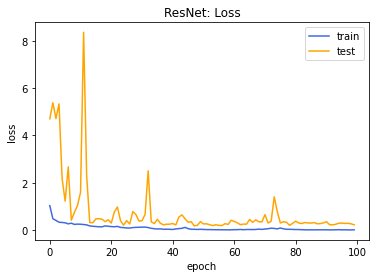

In [13]:
plt.plot(train_loss_num ,label='train',color='royalblue')
plt.plot(test_loss_num ,label='test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("ResNet: Loss")
plt.legend()
plt.show()

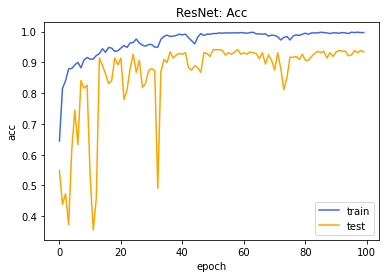

In [14]:
plt.plot(train_acc_num ,label='train',color='royalblue')
plt.plot(test_acc_num ,label='test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("ResNet: Acc")
plt.legend()
plt.show()